<a href="https://colab.research.google.com/github/Kirui-Brian/Biometrics_Systems_Security/blob/main/01_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

Simple implementation of biometric recognition-related metrics.  

Language: Python 3  

Needed libraries:
* matplotlib (https://matplotlib.org/)

## Needed libraries and files

In [38]:
# download of CSV file with biometric system output samples
!pip install gdown
!gdown 1lbYw3ZxXlaxY9yoT8ASeVSlwDfvQjcuF

Downloading...
From: https://drive.google.com/uc?id=1lbYw3ZxXlaxY9yoT8ASeVSlwDfvQjcuF
To: /content/test.csv
100% 979/979 [00:00<00:00, 4.40MB/s]


In [39]:
# sanity check: shows the content of the downloaded file
! wc -l /content/test.csv
! cat /content/test.csv

104 /content/test.csv
# label [0: impostor, 1: genuine], score
# impostor samples
0,0.1056
0,0.5825
0,0.2929
0,0.2607
0,0.2525
0,0.1964
0,0.3671
0,0.2992
0,0.4913
0,0.1809
0,0.3676
0,0.3794
0,0.1118
0,0.5050
0,0.4461
0,0.2626
0,0.2027
0,0.0449
0,0.2442
0,0.1561
0,0.0583
0,0.3961
0,0.1939
0,0.3543
0,0.6246
0,0.0618
0,0.2086
0,0.5374
0,0.2288
0,0.6175
0,0.3381
0,0.2324
0,0.4454
0,0.4229
0,0.5364
0,0.3550
0,0.3981
0,0.5387
0,0.3905
0,0.5475
0,0.3772
0,0.4319
0,0.3054
0,0.5976
0,0.4844
0,0.5278
0,0.3787
0,0.5438
0,0.3291
0,0.0554

# genuine samples
1,0.7392
1,0.5534
1,0.6483
1,0.6937
1,0.5206
1,0.7320
1,1.0362
1,0.6279
1,0.7343
1,0.9175
1,0.6404
1,0.8470
1,0.3945
1,0.5561
1,1.1340
1,0.7414
1,0.3848
1,0.7132
1,0.3967
1,0.5531
1,0.8643
1,1.0094
1,0.6850
1,0.8294
1,0.7978
1,0.7453
1,0.4288
1,0.4733
1,0.8677
1,0.9161
1,0.8347
1,0.6816
1,0.3869
1,1.1378
1,0.8006
1,0.9798
1,0.8548
1,1.0816
1,0.5985
1,0.5999
1,0.7260
1,0.3888
1,0.9227
1,0.6418
1,0.5987
1,0.7297
1,0.9816
1,0.8379
1,0.6145
1,0.9720

In [40]:
  # imported libraries
import matplotlib as plt
print(plt.__version__)

3.10.0


## Auxiliary functions.

In [41]:
# Sums all the values in the given list, using pairwise summation to reduce
# round-off error.
def _pairwise_sum(values):
  sum = float('NaN') # nothing computed, returns not-a-number

  if len(values) == 0:
    sum = 0.0 # nothing to sum, returns zero

  elif len(values) == 1:
    sum = float(values[0]) # one element, returns it

  elif len(values) == 2:
    sum = float(values[0] + values[1]) # two elements, returns their sum

  else:
    i = int(len(values) / 2)
    sum = _pairwise_sum(values[0:i]) + _pairwise_sum(values[i:len(values)]) # recursive call

  return sum

In [42]:
# tests pairwise sum
try:
  _pairwise_sum(None)
except TypeError:
    print("Pairwise sum won't work with None value.")

assert _pairwise_sum([]) == 0.0  # empty array
assert _pairwise_sum([10]) == 10.0  # one element
assert _pairwise_sum([10, 20]) == 30.0  # even number of elements
assert _pairwise_sum([10, 20, -30, -0.5]) == -0.5  # even number of elements
assert _pairwise_sum([10, 20, -30]) == 0.0  # odd number of elements
assert _pairwise_sum([10, 20, -30, -0.5, 0.5]) == 0.0  # odd number of elements

Pairwise sum won't work with None value.


---

In [43]:
# Computes the variance of the given values.
def _compute_var(values):
  var = float('NaN') # nothing computed, returns not-a-number

  if len(values) > 0:
    # mean of values
    mean = _pairwise_sum(values) / len(values)

    # deviations
    deviations = [(v - mean) ** 2.0 for v in values]

    # variance
    var = _pairwise_sum(deviations) / len(deviations)

  return var

In [44]:
# tests calculation of variance
try:
    _compute_var(None)
except TypeError:
    print("Var calculation won't work with None value.")

assert not float('-inf') < _compute_var([]) < float('inf')  # empty array, not a number
assert _compute_var([10]) == 0.0  # one element
assert float('-inf') < _compute_var([10, 20]) < float('inf')  # even number of elements
assert float('-inf') < _compute_var([10, 20, -30, -0.5]) < float('inf')  # even number of elements
assert float('-inf') < _compute_var([10, 20, -30]) < float('inf')  # odd number of elements
assert float('-inf') < _compute_var([10, 20, -30, -0.5, 0.5]) < float('inf')  # odd number of elements

Var calculation won't work with None value.


---

In [45]:
# Loads data from the CSV file stored in the given file path.
# Expected file line format: <label>,<score>
# Comment lines starting with "#" will be ignored.
# Output: array of (<label>,<score>) elements.
def load_data(file_path):
  # output
  output = [] # empty content

  # reads each line of the file,
  # ignoring empty lines and the ones starting with '#'
  with open(file_path) as f:
    for line in f:
      content = line.strip().split(',')
      if len(content) > 0 and len(content[0]) > 0 and content[0][0] != '#': # valid line; other will be ignored
        label = int(content[0])
        score = float(content[1])

        output.append((label, score))

  return output

In [46]:
# tests loading of CSV file
try:
  load_data('nofile.csv')
except FileNotFoundError:
  print("Can't read a file that doesn't exist.")

output = load_data('/content/test.csv')
assert len(output) > 0
print('observations:', len(output), output)

Can't read a file that doesn't exist.
observations: 100 [(0, 0.1056), (0, 0.5825), (0, 0.2929), (0, 0.2607), (0, 0.2525), (0, 0.1964), (0, 0.3671), (0, 0.2992), (0, 0.4913), (0, 0.1809), (0, 0.3676), (0, 0.3794), (0, 0.1118), (0, 0.505), (0, 0.4461), (0, 0.2626), (0, 0.2027), (0, 0.0449), (0, 0.2442), (0, 0.1561), (0, 0.0583), (0, 0.3961), (0, 0.1939), (0, 0.3543), (0, 0.6246), (0, 0.0618), (0, 0.2086), (0, 0.5374), (0, 0.2288), (0, 0.6175), (0, 0.3381), (0, 0.2324), (0, 0.4454), (0, 0.4229), (0, 0.5364), (0, 0.355), (0, 0.3981), (0, 0.5387), (0, 0.3905), (0, 0.5475), (0, 0.3772), (0, 0.4319), (0, 0.3054), (0, 0.5976), (0, 0.4844), (0, 0.5278), (0, 0.3787), (0, 0.5438), (0, 0.3291), (0, 0.0554), (1, 0.7392), (1, 0.5534), (1, 0.6483), (1, 0.6937), (1, 0.5206), (1, 0.732), (1, 1.0362), (1, 0.6279), (1, 0.7343), (1, 0.9175), (1, 0.6404), (1, 0.847), (1, 0.3945), (1, 0.5561), (1, 1.134), (1, 0.7414), (1, 0.3848), (1, 0.7132), (1, 0.3967), (1, 0.5531), (1, 0.8643), (1, 1.0094), (1, 0.685), 

---

## d' Implementation

In [47]:
# Computes d-prime for the given observations.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# If either the number of impostors or genuine observations is zero,
# it returns 'NaN' as d-prime.
def compute_d_prime(observations):
  # output
  d_prime = float('NaN') # nothing computed, returns not-a-number

  # separates genuine and impostor scores
  genuine_scores = []
  impostor_scores = []

  # for each given observation
  for obs in observations:
    if obs[0] == 0:  # impostor
      impostor_scores.append(obs[1])
    else:  # genuine
      genuine_scores.append(obs[1])

  # if there are values for both classes (impostor and genuine)
  if len(genuine_scores) > 0 and len(impostor_scores) > 0:
    # computes mean values
    genuine_mean = _pairwise_sum(genuine_scores) / len(genuine_scores)
    impostor_mean = _pairwise_sum(impostor_scores) / len(impostor_scores)

    # computes variances
    genuine_var = _compute_var(genuine_scores)
    impostor_var = _compute_var(impostor_scores)

    # d-prime computation
    d_prime = 2.0 ** 0.5 * abs(genuine_mean - impostor_mean) / (genuine_var + impostor_var) ** 0.5

  return d_prime

In [48]:
# tests d-prime computation
try:
    compute_d_prime(None)
except TypeError:
    print("d-prime calculation won't work on None value.")

try:
    compute_d_prime([0])
except TypeError:
    print("d-prime calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_d_prime([]) < float('inf')  # empty array, not a number
assert not float('-inf') < compute_d_prime([(0, 0.1)]) < float('inf')  # missing genuine, not a number
assert not float('-inf') < compute_d_prime([(1, 0.1)]) < float('inf')  # missing impostors, not a number

d_prime = compute_d_prime([(0, 2), (0, 4), (1, 0), (1, 2)])
assert d_prime == 2.0

d-prime calculation won't work on None value.
d-prime calculation won't work on arrays not containing (<label>,<score>) elements.


---
### Exercise 1
Compute d' for the content of <code>/content/test.csv</code>.

In [49]:
# add your code here
observations = load_data('/content/test.csv')
d_prime_value = compute_d_prime(observations)
print(f"The d-prime value for /content/test.csv is: {d_prime_value:.2f}")

The d-prime value for /content/test.csv is: 2.13


---
## FMR and FNMR Implementation

In [50]:
# Computes FMR from the given similarity observations,
# according to the given threshold.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# If the number of impostors is zero, it returns 'NaN' as FMR.
def compute_sim_fmr(observations, threshold):
  fmr = float('NaN') # nothing computed, returns not-a-number

  # counters
  impostor_count = 0
  false_match_count = 0

  # for each observation
  for obs in observations:
    if obs[0] == 0:  # impostor
      impostor_count = impostor_count + 1
      if obs[1] >= threshold:
        false_match_count = false_match_count + 1

  # FMR computation
  if impostor_count > 0:
    fmr = false_match_count / impostor_count

  return fmr

In [51]:
# tests FMR computation
try:
    compute_sim_fmr(None, 0.0)
except TypeError:
    print("FMR calculation won't work on None value.")

try:
    compute_sim_fmr([0], 0.0)
except TypeError:
    print("FMR calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_sim_fmr([], 0.0) < float('inf')  # empty array, not a number
assert float('-inf') < compute_sim_fmr([(0, 0.1)], 0.0) < float('inf')  # missing genuine, ok
assert not float('-inf') < compute_sim_fmr([(1, 0.1)], 0.0) < float('inf')  # missing impostors, not a number

fmr = compute_sim_fmr([(0, 0.1), (0, 0.3), (1, 0.0)], 0.25)
assert fmr == 0.5

fmr = compute_sim_fmr([(0, 0.1), (0, 0.3), (1, 0.0)], 0.35)
assert fmr == 0.0

fmr = compute_sim_fmr([(0, 0.1), (0, 0.3), (1, 0.0)], 0.05)
assert fmr == 1.0


FMR calculation won't work on None value.
FMR calculation won't work on arrays not containing (<label>,<score>) elements.


---
### Exercise 2
What is the meaning of the threshold?

*Add your explanation here:*

In biometric recognition systems, a **threshold** is a specific score value used to make a decision about a biometric sample.When a biometric system system generates a similarity score say between an input sample and a stored template, this score is compared against threshold. If the score meets or exceeds the threshold, the system makes an acceptance decision, say authenticates the user, identifies a match. If the score falls below the thrshold, a rejection decision is made.
---

In [52]:
# Computes FNMR from the given similarity observations,
# according to the given threshold.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# If the number of genuine observations is zero, it returns 'NaN' as FNMR.
def compute_sim_fnmr(observations, threshold):
  fnmr = float('NaN') # nothing computed, returns not-a-number

  # counters
  genuine_count = 0
  false_non_match_count = 0

  # for each observation
  for obs in observations:
    if obs[0] != 0:  # genuine observation
      genuine_count = genuine_count + 1

      if obs[1] < threshold:
        false_non_match_count = false_non_match_count + 1

  # FNMR computation
  if genuine_count > 0:
    fnmr = false_non_match_count / genuine_count

  return fnmr

In [53]:
# tests FNMR computation
try:
    compute_sim_fnmr(None, 0.0)
except TypeError:
    print("FNMR calculation won't work on None value.")

try:
    compute_sim_fnmr([0], 0.0)
except TypeError:
    print("FNMR calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_sim_fnmr([], 0.0) < float('inf')  # empty array, not a number
assert not float('-inf') < compute_sim_fnmr([(0, 0.1)], 0.0) < float('inf')  # missing genuine, not a number
assert float('-inf') < compute_sim_fnmr([(1, 0.1)], 0.0) < float('inf')  # missing impostors, ok

fnmr = compute_sim_fnmr([(0, 0.0), (1, 0.1), (1, 0.3)], 0.25)
assert fnmr == 0.5

fnmr = compute_sim_fnmr([(0, 0.0), (1, 0.1), (1, 0.3)], 0.5)
assert fnmr == 1.0

fnmr = compute_sim_fnmr([(0, 0.0), (1, 0.1), (1, 0.3)], 0.05)
assert fnmr == 0.0

FNMR calculation won't work on None value.
FNMR calculation won't work on arrays not containing (<label>,<score>) elements.


---

In [54]:
# Computes FNMR and FMR at EER from the given similarity observations.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# Output: FNMR, FMR, EER_THRESHOLD.
# If either the number of impostors or genuine observations is zero,
# it returns 'NaN', 'NaN', 'NaN'.
def compute_sim_fmr_fnmr_eer(observations):
    # computed FNMR and FMR at EER, and EER threshold
    output_fnmr = float('NaN') # nothing computed, returns not-a-number
    output_fmr = float('NaN')
    output_threshold = float('NaN')

    # holds the difference between FMR and FNMR
    fnmr_fmr_diff = float('inf') # a very large float

    # sorted list of scores
    scores = sorted([obs[1] for obs in observations])
    if len(scores) > 0:
      # for each score taken as threshold
      for threshold in scores:
        current_fnmr = compute_sim_fnmr(observations, threshold)
        current_fmr = compute_sim_fmr(observations, threshold)

        # cancels computation if any of the FNMR or FMR values are 'NaN' (impossible to compute them)
        if not float('-inf') < current_fnmr < float('inf') or not float('-inf') < current_fmr < float('inf'):
          break

        # updates the difference between FNMR and FMR, if it is the case
        current_diff = abs(current_fnmr - current_fmr)
        if current_diff <= fnmr_fmr_diff:
          fnmr_fmr_diff = current_diff

          # updates current values
          output_fnmr = current_fnmr
          output_fmr = current_fmr
          output_threshold = threshold

        else:
          # difference will start to increase, nothing to do anymore
          break

    return output_fnmr, output_fmr, output_threshold

In [55]:
# tests FNMR and FMR at EER
try:
    compute_sim_fmr_fnmr_eer(None)
except TypeError:
    print("FNMR, FMR @ EER calculation won't work on None value.")

try:
    compute_sim_fmr_fnmr_eer([0])
except TypeError:
    print("FNMR, FMR @ EER calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_sim_fmr_fnmr_eer([])[0] < float('inf')  # empty array, not a number
assert not float('-inf') < compute_sim_fmr_fnmr_eer([])[1] < float('inf')  # empty array, not a number
assert not float('-inf') < compute_sim_fmr_fnmr_eer([])[2] < float('inf')  # empty array, not a number

assert not float('-inf') < compute_sim_fmr_fnmr_eer([(0, 0.1)])[0] < float('inf')  # missing genuine, nan
assert not float('-inf') < compute_sim_fmr_fnmr_eer([(0, 0.1)])[1] < float('inf')  # missing genuine, nan
assert not float('-inf') < compute_sim_fmr_fnmr_eer([(0, 0.1)])[2] < float('inf')  # missing genuine, nan

assert not float('-inf') < compute_sim_fmr_fnmr_eer([(1, 0.1)])[0] < float('inf')  # missing impostors, nan
assert not float('-inf') < compute_sim_fmr_fnmr_eer([(1, 0.1)])[1] < float('inf')  # missing impostors, nan
assert not float('-inf') < compute_sim_fmr_fnmr_eer([(1, 0.1)])[2] < float('inf')  # missing impostors, nan

fnmr, fmr, eer = compute_sim_fmr_fnmr_eer([(0, 0.2), (0, 0.3), (0, 0.4), (1, 0.5), (1, 0.6), (1, 0.7)])
assert fnmr == 0.0
assert fmr == 0.0
assert eer == 0.5

FNMR, FMR @ EER calculation won't work on None value.
FNMR, FMR @ EER calculation won't work on arrays not containing (<label>,<score>) elements.


---
### Exercise 3
Compute FNMR and FMR at EER for the content of <code>/content/test.csv</code>.

In [56]:
# add your code here
observations = load_data('/content/test.csv')
fnmr_eer, fmr_eer, eer_threshold = compute_sim_fmr_fnmr_eer(observations)
print(f"FNMR at EER: {fnmr_eer:.2f}")
print(f"FMR at EER: {fmr_eer:.2f}")
print(f"EER Threshold: {eer_threshold:.2f}")


FNMR at EER: 0.16
FMR at EER: 0.16
EER Threshold: 0.54


---
## FMR versus TMR AUC

In [57]:
# Computes FMR x TMR (a.k.a. 1.0 - FNMR) AUC from the given similarity observations.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# Output: AUC, array with FMR values, array with TMR values.
# If either the number of impostors or genuine observations is zero, it returns 'NaN', [], [].
def compute_sim_fmr_tmr_auc(observations):
    # output values
    auc = float('NaN') # nothing computed, returns not-a-number
    fmrs = []
    tmrs = []

    # sorted list of scores
    scores = sorted([obs[1] for obs in observations])
    if len(scores) > 0:
      # for each score taken as a threshold
      for threshold in scores:
        current_fmr = compute_sim_fmr(observations, threshold)
        current_fnmr = compute_sim_fnmr(observations, threshold)

        # cancels computation if any of the FNMR or FMR values are 'NaN' (impossible to compute them)
        if not float('-inf') < current_fmr < float('inf') or not float('-inf') < current_fnmr < float('inf'):
          break

        # adds the computed values to the proper lists
        fmrs.append(current_fmr)
        tmrs.append(1.0 - current_fnmr)

      # computes the AUC
      if len(fmrs) > 0 and len(tmrs) > 0:
        # adds the last points on [0.0, 0.0] for completeness
        fmrs.append(0.0)
        tmrs.append(0.0)

        auc_parts = []
        for i in range(len(fmrs) - 1):
          auc_parts.append(abs(fmrs[i] - fmrs[i + 1]) * (tmrs[i] + tmrs[i + 1]) / 2.0)
        auc = _pairwise_sum(auc_parts)

    return auc, fmrs, tmrs

In [58]:
# tests FMR x FMR AUC
try:
    compute_sim_fmr_tmr_auc(None)
except TypeError:
    print("FMR x TMR AUC calculation won't work on None value.")

try:
    compute_sim_fmr_tmr_auc([0])
except TypeError:
    print("FMR x TMR AUC calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_sim_fmr_tmr_auc([])[0] < float('inf')  # empty array, not a number
assert len(compute_sim_fmr_tmr_auc([])[1]) == 0 # empty array, nothing to do
assert len(compute_sim_fmr_tmr_auc([])[2]) == 0 # empty array, nothing to do

assert not float('-inf') < compute_sim_fmr_tmr_auc([(0, 0.1)])[0] < float('inf')  # missing genuine, nan
assert len(compute_sim_fmr_tmr_auc([(0, 0.1)])[1]) == 0 # missing genuine, nothing to do
assert len(compute_sim_fmr_tmr_auc([(0, 0.1)])[2]) == 0 # missing genuine, nothing to do

assert not float('-inf') < compute_sim_fmr_tmr_auc([(1, 0.1)])[0] < float('inf')  # missing impostors, nan
assert len(compute_sim_fmr_tmr_auc([(1, 0.1)])[1]) == 0 # missing impostors, nothing to do
assert len(compute_sim_fmr_tmr_auc([(1, 0.1)])[2]) == 0 # missing impostors, nothing to do

auc, fmrs, tmrs = compute_sim_fmr_tmr_auc([(0, 0.2), (0, 0.3), (0, 0.4), (1, 0.5), (1, 0.6), (1, 0.7)])
#print(auc)
#assert auc == 1.0
assert len(fmrs) > 0
assert len(tmrs) > 0
assert len(fmrs) == len(tmrs)
print('AUC:', auc)
print('FMR:', fmrs)
print('TMR:', tmrs)

FMR x TMR AUC calculation won't work on None value.
FMR x TMR AUC calculation won't work on arrays not containing (<label>,<score>) elements.
AUC: 1.0
FMR: [1.0, 0.6666666666666666, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0]
TMR: [1.0, 1.0, 1.0, 1.0, 0.6666666666666667, 0.33333333333333337, 0.0]


---
### Exercise 4
Compute FMR versus TMR AUC for the content of <code>/content/test.csv</code>.

In [59]:
# add your code here
observations = load_data('/content/test.csv')
auc_value, _, _ = compute_sim_fmr_tmr_auc(observations)
print(f"FMR versus TMR AUC for /content/test.csv is: {auc_value:.2f}")

FMR versus TMR AUC for /content/test.csv is: 0.94


---
## Plot Functions

In [60]:
# Plots the histograms of the scores of the impostors and of the genuine observations together.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
def plot_hist(observations):
    impostors = []
    genuine = []

    for item in observations:
        if item[0] == 0:
            impostors.append(item[1])
        else:
            genuine.append(item[1])

    plt.xlabel('score')
    plt.ylabel('frequency')

    plt.hist(impostors, facecolor='red', alpha=0.5, label='impostor', align='mid')
    plt.hist(genuine, facecolor='blue', alpha=0.5, label='genuine', align='mid')
    plt.legend(loc='lower right')

    d_prime = compute_d_prime(observations)
    if float('-inf') < d_prime < float('inf'):
        plt.title("Score distribution, d'=" + '{:.2f}'.format(d_prime))
    else:
        plt.title('Score distribution')

    plt.show()

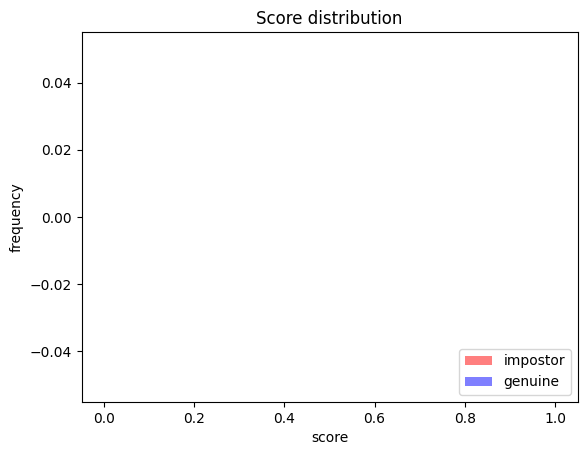

In [61]:
# histogram plot test 1
import matplotlib.pyplot as plt
plot_hist([])

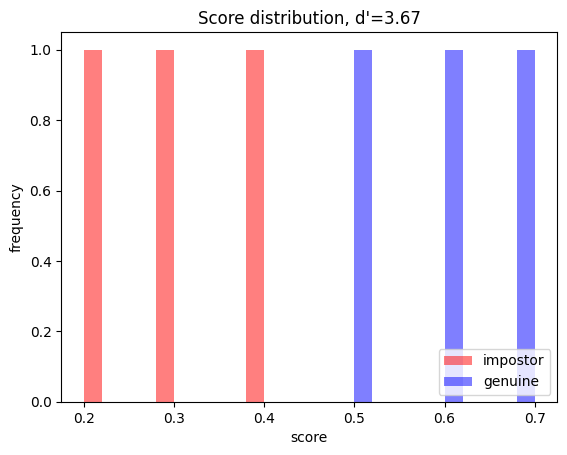

In [62]:
# histogram plot test 2
import matplotlib.pyplot as plt
plot_hist([(0, 0.2), (0, 0.3), (0, 0.4), (1, 0.5), (1, 0.6), (1, 0.7)])

---
### Exercise 5
Plot the histogram for the content of <code>/content/test.csv</code>.

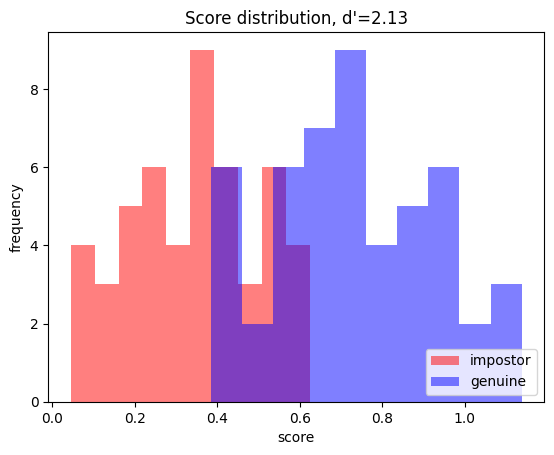

In [63]:
# add your code here
observations = load_data('/content/test.csv')
plot_hist(observations)

---

In [64]:
# Plots the FMR x TMR AUC from the given similarity observations.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
def plot_sim_fmr_tmr_auc(observations):
    plt.xlabel('FMR')
    plt.ylabel('TMR')

    auc, fmrs, tmrs = compute_sim_fmr_tmr_auc(observations)
    if float('-inf') < auc < float('inf'):
        plt.plot(fmrs, tmrs, label='AUC: ' + '{:.2f}'.format(auc))
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.legend(loc='lower right')

    plt.title('ROC curve')
    plt.show()

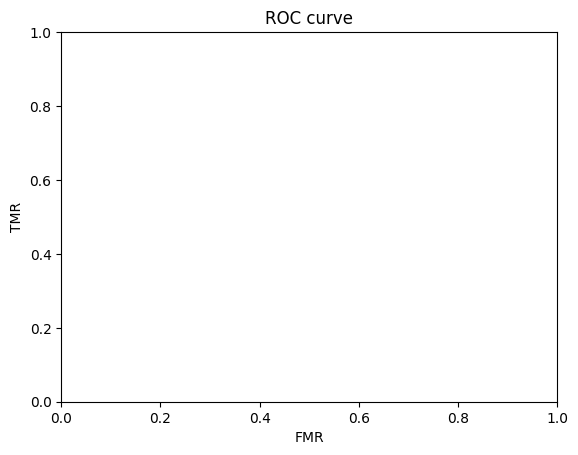

In [65]:
# AUC plot test 1
import matplotlib.pyplot as plt
plot_sim_fmr_tmr_auc([])

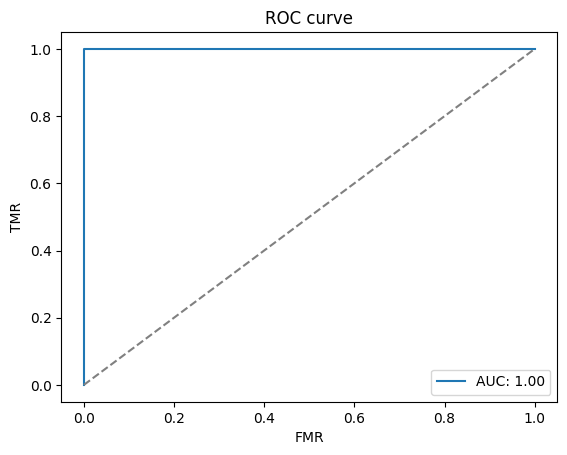

In [66]:
# AUC plot test 2
import matplotlib.pyplot as plt
plot_sim_fmr_tmr_auc([(0, 0.2), (0, 0.3), (0, 0.4), (1, 0.5), (1, 0.6), (1, 0.7)])



---
### Exercise 6
Plot the AUC for the content of <code>/content/test.csv</code>.

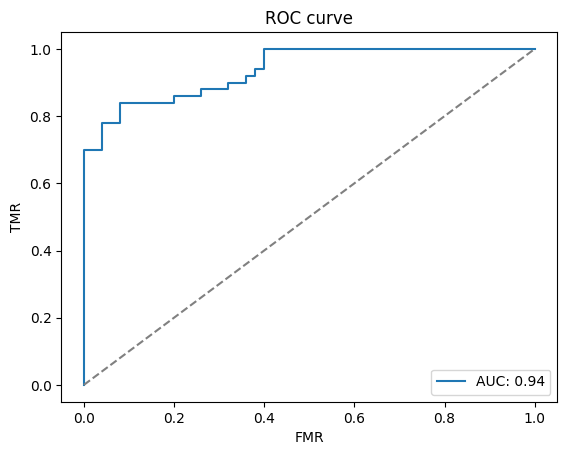

In [67]:
# add you code here
observations = load_data('/content/test.csv')
plot_sim_fmr_tmr_auc(observations)

---